<a href="https://colab.research.google.com/github/eedanileiko/Data-Analytics-Portfolio/blob/main/Trees_Danileyko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение, ФКН ВШЭ #

##  Решающие деревья ##



### О задании

В процессе выполнения этого домашнего задания я:

1. Практиковалась использовать решающие деревья из `sklearn` для задачи классификации на простых двумерных датасетах, визуализировала разделяющие плоскости и распознавать переобучение.

2. Реализовала своё решающее дерево для задачи классификации и сравнила его со стандартной имплементацией.

3. Исследовала влияние бэггинга на смещение и разброс.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ssl
import certifi

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
sns.set(style='whitegrid')

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

## Решающие деревья

### Визуализация

Рассмотрим три простых двумерных датасета, сгенерированных с помощью `make_moons`, `make_circles` и `make_classification`.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification

datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2,
                        class_sep=0.75, random_state=3, n_redundant=0)
]

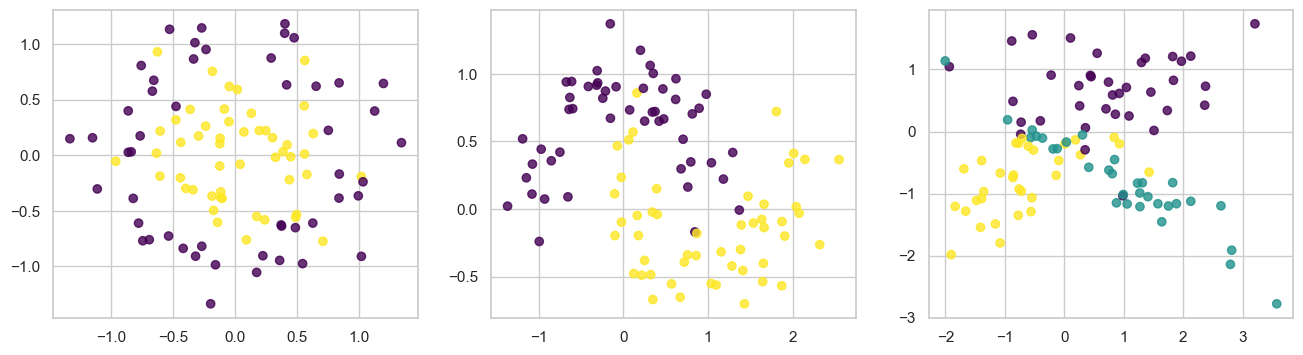

In [ ]:
plt.figure(figsize=(16, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap="viridis", alpha=0.8)

__ 1. __

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности и посчитайте accuracy на обучающей и тестовой выборках. Прокомментируйте, в каких случаях и почему модель переобучается.

Точность 1ого дерева, построенного с заданным ограничением на глубину: 0.7
Точность 1ого дерева, построенного без ограничения на глубину: 0.65
Точность на трейне 1ого дерева, построенного с заданным ограничением на глубину: 0.8875
Точность на трейне 1ого дерева, построенного без ограничения на глубину: 1.0


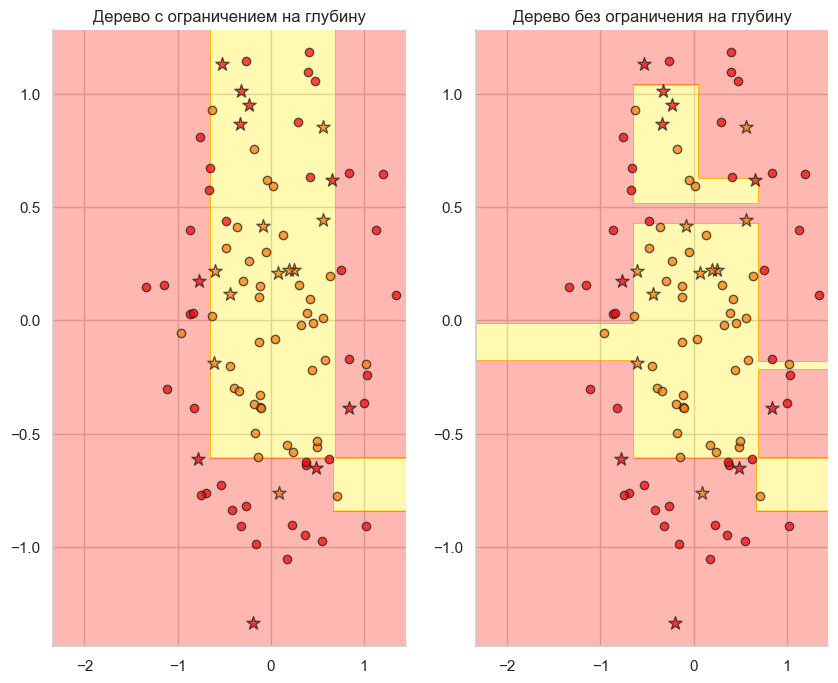

Точность 2ого дерева, построенного с заданным ограничением на глубину: 0.85
Точность 2ого дерева, построенного без ограничения на глубину: 0.9
Точность на трейне 2ого дерева, построенного с заданным ограничением на глубину: 0.925
Точность на трейне 2ого дерева, построенного без ограничения на глубину: 1.0


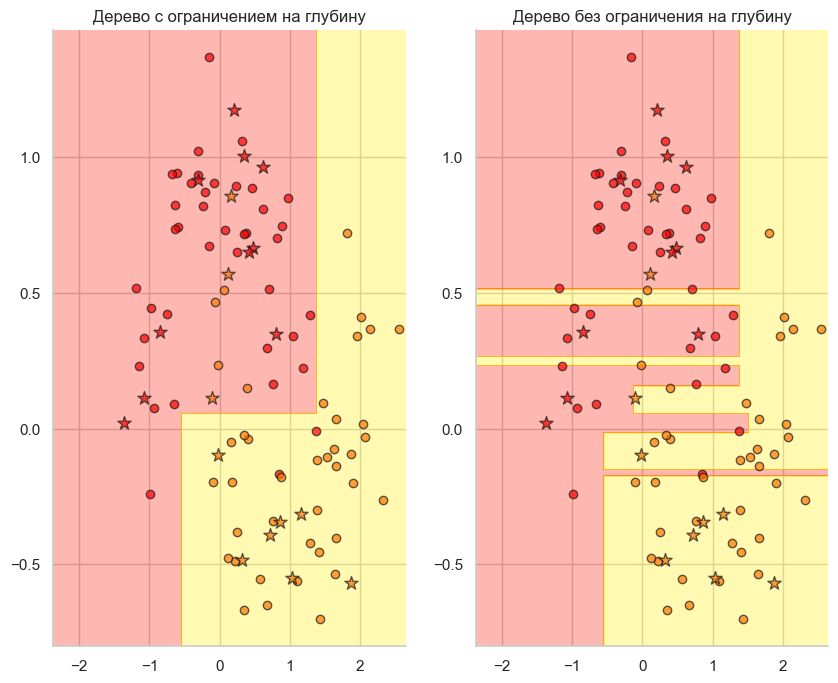

Точность 3ого дерева, построенного с заданным ограничением на глубину: 0.8
Точность 3ого дерева, построенного без ограничения на глубину: 0.7
Точность на трейне 3ого дерева, построенного с заданным ограничением на глубину: 0.9375
Точность на трейне 3ого дерева, построенного без ограничения на глубину: 1.0


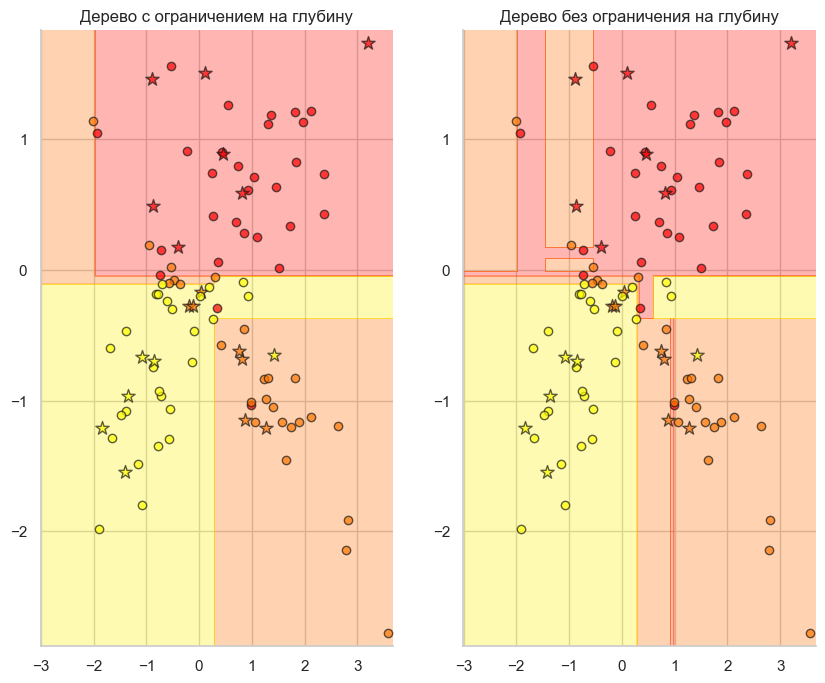

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_tr_all=[]
X_tst_all=[]
y_tr_all=[]
y_tst_all=[]
datasets_names=['moons','circles','classification']
for i, (x, y) in enumerate(datasets):
    X=x.copy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
    X_tr_all.append(X_train)
    X_tst_all.append(X_test)
    y_tr_all.append(y_train)
    y_tst_all.append(y_test)
    # обучим два дерева: первое будет иметь ограничение на глубину, второе - нет
    tree_with_limits = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_with_limits.fit(X_train, y_train)
    tree_without_limits = DecisionTreeClassifier(max_depth=None, random_state=42)
    tree_without_limits.fit(X_train, y_train)

    # получим предсказания для тестовой выборки для обеих моделей и посчитаем accuracy
    y_predicted_with_limits = tree_with_limits.predict(X_test)
    accuracy_with_limits = accuracy_score(y_test, y_predicted_with_limits)
    y_predicted_without_limits = tree_without_limits.predict(X_test)
    accuracy_without_limits = accuracy_score(y_test, y_predicted_without_limits)
    train_acc_with_limits = accuracy_score(y_train, tree_with_limits.predict(X_train))
    train_acc_without_limits = accuracy_score(y_train, tree_without_limits.predict(X_train))

    print("Точность "+str(i+1)+"ого дерева, построенного с заданным ограничением на глубину:", accuracy_with_limits)
    print("Точность "+str(i+1)+"ого дерева, построенного без ограничения на глубину:", accuracy_without_limits)
    print("Точность на трейне "+str(i+1)+"ого дерева, построенного с заданным ограничением на глубину:", train_acc_with_limits)
    print("Точность на трейне "+str(i+1)+"ого дерева, построенного без ограничения на глубину:", train_acc_without_limits)

    colors = ['#FF0000', '#FF7700', '#FFFF00']

    # визуализируем результаты
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))

    z_with_limits = tree_with_limits.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    z_without_limits = tree_without_limits.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].contourf(xx, yy, z_with_limits, alpha=0.3, cmap=plt.cm.autumn)
    ax[0].set_title("Дерево с ограничением на глубину")
    for i, color in zip(range(3), colors):
        ax[0].scatter(X_train[np.where(y_train == i), 0], X_train[np.where(y_train == i), 1], c=color, edgecolor='k', marker='o', alpha=0.7)
        ax[0].scatter(X_test[np.where(y_test == i), 0], X_test[np.where(y_test == i), 1], c=color, edgecolor='k', marker='*', s=100, alpha=0.7)

    ax[1].contourf(xx, yy, z_without_limits, alpha=0.3, cmap=plt.cm.autumn)
    ax[1].set_title("Дерево без ограничения на глубину")
    for i, color in zip(range(3), colors):
        ax[1].scatter(X_train[np.where(y_train == i), 0], X_train[np.where(y_train == i), 1], c=color, edgecolor='k', marker='o', alpha=0.7)
        ax[1].scatter(X_test[np.where(y_test == i), 0], X_test[np.where(y_test == i), 1], c=color, edgecolor='k', marker='*', s=100, alpha=0.7)


    for ax_ in ax:
        ax_.spines['top'].set_visible(False)
        ax_.spines['right'].set_visible(False)

    plt.show()



__Ответ:__ <font color='blue'> Мы видим явной переобучение на трейне, это же и показывает график (визуально границы становятся слишком детализированными), он подстраивается под каждое значение выборки (от этого и accuracy 1), но эта ситуация решается при заданном ограчении на глубину. Если разрешить дереву расти без ограничения на глубину, то оно будет разбивать пространство на очень маленькие области, пытаясь идеально классифицировать каждый объект обучающей выборки. Это приводит к тому, что оно идеально запоминает тренировочные примеры, но плохо распространяет знания на новые данные</font>

__Задание 2. __

Выберите один датасет из предыдущего задания и исследуйте на его примере влияние на итоговое качество двух гиперпараметров одновременно. Для каждой пары значений посчитайте accuracy на обучающей и тестовой выборках и сохраните результаты в таблицу.

Визуализируйте зависимость качества на тестовой выборке от значений выбранных вами гиперпараметров. При каких значениях наблюдается лучшее соотношение разброса и смещения? Почему вы сделали такой вывод?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train,X_test, y_train,y_test=X_tr_all[0],X_tst_all[0],y_tr_all[0],y_tst_all[0]
max_depth_values = [2, 3, 4, 5, 7, 10, None]
min_samples_split_values = [2, 5, 10, 20, 50]

results = []
for depth in max_depth_values:
    for min_split in min_samples_split_values:
        model = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_split=min_split,
            random_state=42
        )
        model.fit(X_train, y_train)
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        results.append([depth, min_split, train_acc, test_acc])
df = pd.DataFrame(results, columns=["max_depth", "min_samples_split","train_acc", "test_acc"])
df.head()


,max_depth,min_samples_split,train_acc,test_acc
0,2.0,2,0.7875,0.65
1,2.0,5,0.7875,0.65
2,2.0,10,0.7875,0.65
3,2.0,20,0.7875,0.65
4,2.0,50,0.7875,0.65


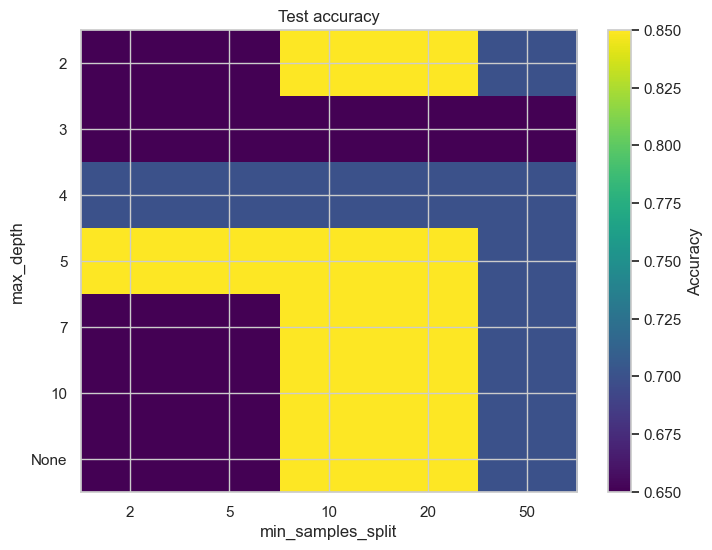

In [ ]:
pivot = df.pivot(index="max_depth", columns="min_samples_split", values="test_acc")
plt.figure(figsize=(8,6))
plt.title("Test accuracy")
plt.imshow(pivot, cmap="viridis", aspect="auto")
plt.colorbar(label="Accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.xticks(range(len(min_samples_split_values)), min_samples_split_values)
plt.yticks(range(len(max_depth_values)), [str(v) for v in max_depth_values])
plt.show()

__Ответ:__ \
<font color='blue'>**Выбранные гиперпараметры**\
**max_depth** — контролирует сложность модели\
**min_samples_split** — минимальное число объектов для расщепления узла\
Эти параметры влияют на смещение и разброс.
Лучшее качество достигается при умеренной глубине дерева (5–7) и ограничении минимального числа объектов в узле (10–20).
Малые max_depth дают сильное недообучение, так как модель слишком простая для нелинейных данных.\
Большие max_depth в сочетании с min_samples_split=2–5 приводят к переобучению: дерево начинает подгоняться под шум и теряет способность к обобщению.</font>

### Решающие деревья своими руками (6 баллов)

Итак, пришло время реализовать свой класс для обучения решающего дерева.

__Задание 3. (1.5 балла)__

Реализуйте функцию `find_best_split` из модуля `hw5code.py`, её сигнатура прописана в соответствующем файле.

Напоминаем, что под критерием Джини подразумевается следующая функция качества разбиения:

$$
Q(R) = -\frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r),
$$

где $R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево соответственно.

Функция неоднородности (критерий Джини) для множества $R$ определяется как

$$
H(R) = 1 - \sum_{k=1}^{K} p_k^2,
$$

где $p_k$ - доля объектов класса $k$ в множестве $R$, а $K$ - число различных классов в текущем узле.

Замечание: при $K=2$ формула сводится к бинарному случаю $H(R)=1-p_0^2-p_1^2$, где $p_1$ и $p_0$ $-$ доля объектов классов $1$ и $0$ соответственно.


In [ ]:
import numpy as np
from collections import Counter

In [ ]:
def find_best_split(feature_vector, target_vector):
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются
    * В качестве порогов нужно брать среднее двух соседних при сортировке значений признака
    * Поведение функции в случае константного признака может быть любым
    * При одинаковых приростах критерия Джини нужно выбирать минимальный сплит
    * Критерий Джини должен поддерживать многоклассовый случай:
    * H(R) = 1 - sum_k p_k^2, где p_k - доля класса k в узле. Для K=2 формула сводится к 1 - p0^2 - p1^2.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds, len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature= np.asarray(feature_vector)
    target = np.asarray(target_vector)
    order = np.argsort(feature)
    X_sorted = feature[order]
    y_sorted =target[order]

    N = len(y_sorted)
    diff = X_sorted[1:] != X_sorted[:-1]
    thresholds = ((X_sorted[1:] + X_sorted[:-1]) / 2)[diff]
    classes, y_idx = np.unique(y_sorted, return_inverse=True)
    count_class = len(classes)

    one_hot = np.eye(count_class)[y_idx]
    cum_counts = np.cumsum(one_hot, axis=0)
    split_indices = np.where(diff)[0] + 1
    left_sizes = split_indices
    right_sizes = N - left_sizes
    left_counts = cum_counts[split_indices - 1]
    total_counts = cum_counts[-1]
    right_counts = total_counts - left_counts
    left_p = left_counts / left_sizes[:, None]
    right_p = right_counts / right_sizes[:, None]
    G_left = 1 - np.sum(left_p ** 2, axis=1)
    G_right = 1 - np.sum(right_p ** 2, axis=1)

    ginis = (left_sizes / N) * G_left + (right_sizes / N) * G_right
    best_idx = np.argmin(ginis)
    threshold_best = thresholds[best_idx]
    gini_best = ginis[best_idx]

    return thresholds, ginis, threshold_best, gini_best

__Задание 4. (0.75 балл)__

Загрузите датасет [Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance). Поработайте с данными: создайте бинарный признак `pass`, который будет равен единице, если итоговая оценка `G3` не меньше $10$, и нулю в противном случае. Затем выберите пять числовых признаков, среди которых должны быть как очень информативные, так и потенциально неинформативные. Коротко обоснуйте свой выбор.

Для каждого из выбранных признаков постройте график зависимости критерия Джини от возможного порога разделения. Отобразите все пять кривых на одном рисунке.

Для каждого из выбранных признаков дополнительно визуализируйте зависимость
"значение признака - класс (0/1)".

> Можно, например, построить scatter-график, где по оси X - значение признака, а по оси Y - бинарный признак `pass` (при необходимости используйте небольшой jitter по оси Y и/или прозрачность alpha, чтобы лучше видеть плотность точек); или использовать эквивалентную по смыслу визуализацию (например, `seaborn.stripplot` / `swarmplot`), из которой видно, как распределены значения признака внутри каждого класса.

<font color='blue'>Мы берем таблицу student-mat, ато их там много</font>

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('student-mat.csv', sep=';')
df['pass'] = (df['G3'] >= 10).astype(int)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,1


<font color='blue'>Теперь выбираем итоговые признаки</font>

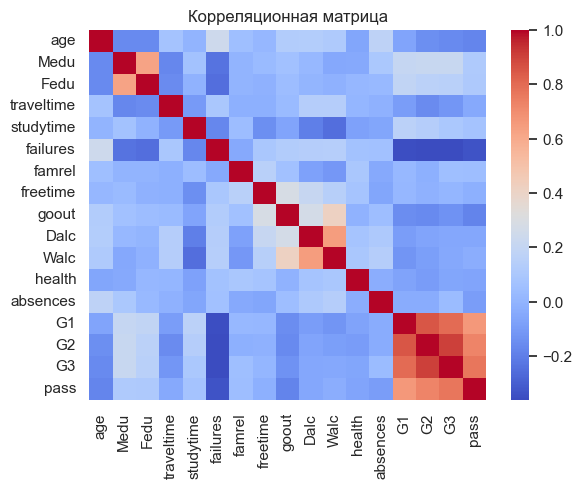

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns
corr=df[numeric_cols].corr()
sns.heatmap(corr,cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

<font color='blue'>**Признаки**</font>
1. G2 - second period grade (numeric: from 0 to 20) логично, что оценки предыдущих периодов сильно влияют **информативный**
2. G1 - first period grade (numeric: from 0 to 20) логично, что оценки предыдущих периодов сильно влияют **информативный**
3. failures - number of past class failures (numeric: n if 1<=n<3, else 4) чем больше пропускаешь, тем хуже **информативный**
4. age- student's age (numeric: from 15 to 22) возраст лишь цифра) **неинформативный**
5. freetime -  free time after school (numeric: from 1 - very low to 5 - very high) признак может по-разному сказаться, в завсисмости от провождения времени **неинформативный**

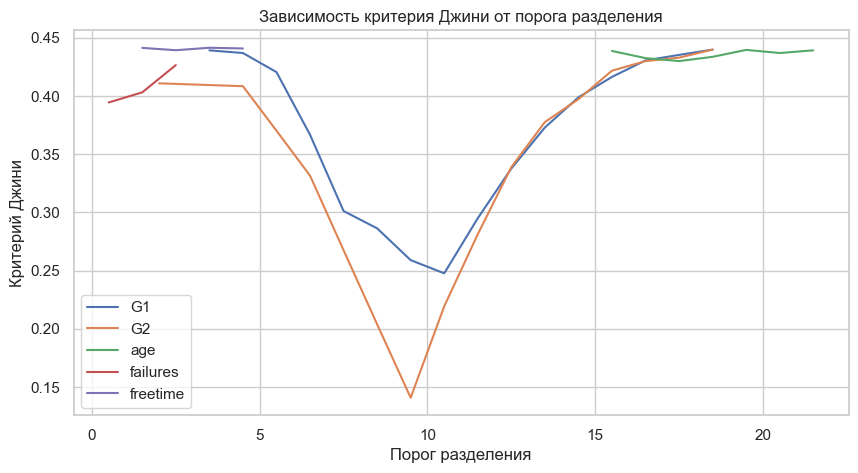

In [ ]:
features = ['G1', 'G2', 'age', 'failures', 'freetime']
y = df['pass'].values
plt.figure(figsize=(10, 5))
for i in features:
    X = df[i].values
    thresholds, ginis, th_best, gini_best = find_best_split(X, y)
    plt.plot(thresholds, ginis, label=i)
plt.xlabel('Порог разделения')
plt.ylabel('Критерий Джини')
plt.legend()
plt.title('Зависимость критерия Джини от порога разделения')
plt.show()

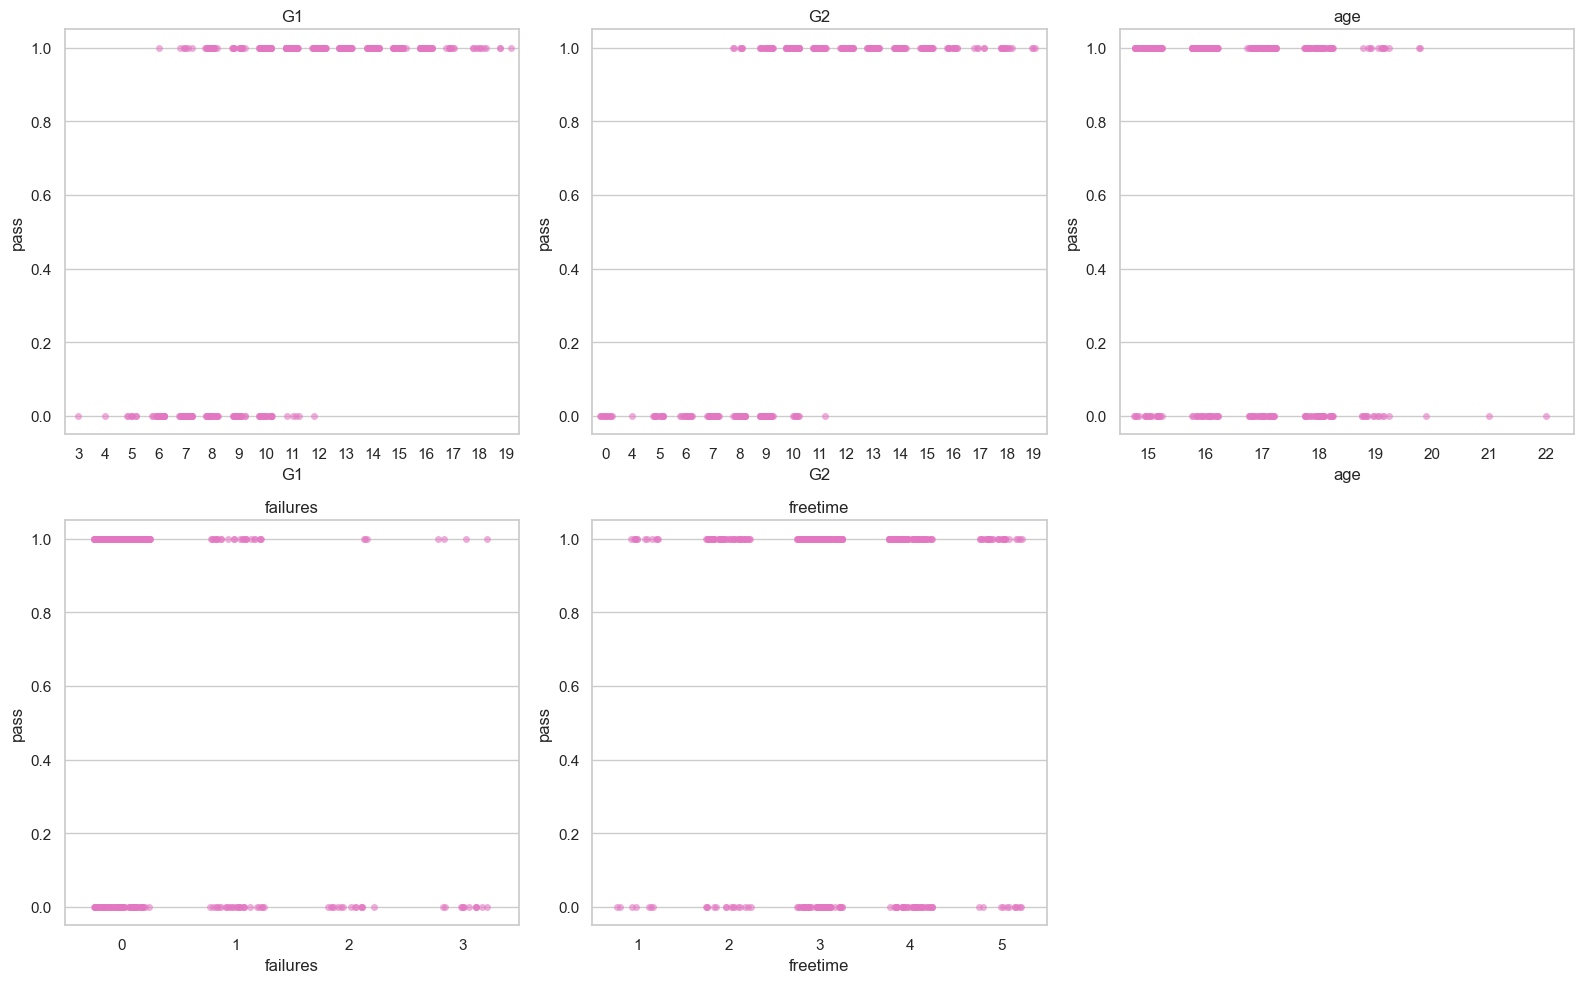

In [ ]:
plt.figure(figsize=(16, 10))
for i, f in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.stripplot(data=df, x=f, y="pass", jitter=0.25, alpha=0.6, color="tab:pink")
    plt.title(f"{f}")
    plt.xlabel(f)
    plt.ylabel("pass")
plt.tight_layout()
plt.show()


<font color='blue'>**Выводы с графиков (почти как я и говорила в целом):** </font>
1. G1 - информативный признак
2. G2 - информативный признак
3. failures - линия почти плоская, лёгкие колебания - признак слабый, но не полностью
4. age - почти идеально плоская линия - признак слабый
5. freetime - линия также почти плоская, без резких падений - признак слабый

__Задание 5. (0.25 балла)__

На основании построенных в прошлом задании графиков ответьте на следующие вопросы:

1. По какому признаку нужно производить деление выборки на два поддерева? Почему?

2. Согласуется ли этот результат с тем, что видно на scatter-графиках? Совпадают ли выводы?

3. Как выглядят кривые для тех признаков, по которым классы разделяются почти идеально? Чем отличаются от них кривые для признаков, по которым деление практически невозможно?

<font color='blue'>**Ответ:** </font>
1. Оптимальное разбиение достигается по признаку G2, поскольку его кривая критерия Джини имеет самый глубокий минимум, то есть этот признак обеспечивает наиболее сильное разделение классов (но G1 тоже норм)
2. Для G2 существует почти идеальная граница,для G1 картина похожая,но немного более размытая, для признаков age, failures, freetime распределения классов заметно пересекаются, поэтому они плохо подходят для разделения.
3. Информативные признаки имеют резко выраженный минимум критерия Джини, кривая просаживается вниз. Слабые признаки: кривые почти плоские, без глубоких провалов, то есть значение Джини мало меняется при изменении порога.

__Задание 6. (1.5 балла)__

Разберитесь с уже написанным кодом в классе `DecisionTree` модуля `hw5code.py`. Исправьте ошибки в методе `_fit_node`, а также реализуйте `_predict_node`.

В данном задании:
* построение дерева осуществляется согласно базовому жадному алгоритму, предложенному на лекции
* выбор лучшего разбиения необходимо производить по критерию Джини
* в качестве критерия останова используется следующий: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
* ответ в листе $-$ это наиболее часто встречающийся в нём класс
* для категориальных признаков выполняется преобразование, описанное на лекции (можете найти его в конспекте в разделе «Учёт категориальных признаков»)

In [ ]:
class DecisionTree:
    """
    Простое классификационное дерево, поддерживающее:
    * real / categorical признаки
    * binary и multiclass цели (метки могут быть числами или строками)
    * ограничения max_depth, min_samples_split, min_samples_leaf (как в sklearn по смыслу)

    ВНИМАНИЕ: в методе _fit_node ниже намеренно оставлены ошибки и бинарные допущения.
    Их нужно исправить в рамках задания.
    """
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if len(np.unique(sub_y)) == 1:
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        global_target = Counter(sub_y).most_common(1)[0][0]
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # ВАЖНО: преобразование категориальных признаков должно работать и для multiclass.
                categories = sub_X[:, feature]
                counts = Counter(categories)
                clicks = Counter(categories[sub_y == Counter(sub_y).most_common(1)[0][0]])
                ratio = {}
                for j in counts:
                    total = counts[j]
                    pos = clicks.get(j, 0)
                    ratio[j] = pos / total

                sorted_cats = [c for c, _ in sorted(ratio.items(), key=lambda x: x[1])]
                categories_map = {j: i for i, j in enumerate(sorted_cats)}

                feature_vector = np.array([categories_map[c] for c in categories])
            else:
                raise ValueError

            if len(np.unique(feature_vector)) == 1:
                continue

            thresholds, ginis, th_best, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini < gini_best:
                gini_best = gini
                feature_best = feature
                split_best = feature_vector < th_best

                if feature_type == "real":
                    threshold_best = th_best
                else:
                    threshold_best = [j for j, idx in categories_map.items() if idx < th_best]

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            node["categories_split"] = threshold_best
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split_best], sub_y[split_best], node["left_child"])
        self._fit_node(sub_X[~split_best], sub_y[~split_best], node["right_child"])
    def _predict_node(self, x, node):
        # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if node["type"] == "terminal":
            return node["class"]
        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] in node["categories_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        pass

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

__Задание 7. (0.5 балла)__

Протестируйте написанное вами решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого необходимо скачать таблицу agaricus-lepiota.data и применить к каждому столбцу LabelEncoder, чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец в рассматриваемой таблице $-$ это целевая переменная ('e' $-$ edible, 'p' $-$ poisonous).

Обучите решающее дерево на $50\%$ случайно выбранных объектов и получите предсказания для оставшейся половины. Вычислите accuracy. Если в предыдущих заданиях вы всё сделали корректно, то у вас должно получиться качество очень близкое единице или даже равное ей.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('agaricus-lepiota.data')
df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [ ]:
df_encoded = df.copy()
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
df_encoded.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [ ]:
X = df_encoded.drop(columns=['p']).values
y = df_encoded['p'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

1.0

<font color='blue'>**ура, победа** </font>

__Задание 8. (1 балл)__

Реализуйте в классе `DecisionTree` поддержку параметров `max_depth`, `min_samples_split` и `min_samples_leaf` по аналогии с `DecisionTreeClassifier`.

In [ ]:
class DecisionTree:
    """
    Простое классификационное дерево, поддерживающее:
    * real / categorical признаки
    * binary и multiclass цели (метки могут быть числами или строками)
    * ограничения max_depth, min_samples_split, min_samples_leaf (как в sklearn по смыслу)

    ВНИМАНИЕ: в методе _fit_node ниже намеренно оставлены ошибки и бинарные допущения.
    Их нужно исправить в рамках задания.
    """
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node,depth=0):
        if len(np.unique(sub_y)) == 1:
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        feature_best, threshold_best, gini_best, split = None, None, None, None
        global_target = Counter(sub_y).most_common(1)[0][0]
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # ВАЖНО: преобразование категориальных признаков должно работать и для multiclass.
                categories = sub_X[:, feature]
                counts = Counter(categories)
                clicks = Counter(categories[sub_y == Counter(sub_y).most_common(1)[0][0]])
                ratio = {}
                for j in counts:
                    total = counts[j]
                    pos = clicks.get(j, 0)
                    ratio[j] = pos / total

                sorted_cats = [c for c, _ in sorted(ratio.items(), key=lambda x: x[1])]
                categories_map = {j: i for i, j in enumerate(sorted_cats)}

                feature_vector = np.array([categories_map[c] for c in categories])
            else:
                raise ValueError

            if len(np.unique(feature_vector)) == 1:
                continue

            thresholds, ginis, th_best, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini < gini_best:
                gini_best = gini
                feature_best = feature
                split_best = feature_vector < th_best

                if feature_type == "real":
                    threshold_best = th_best
                else:
                    threshold_best = [j for j, idx in categories_map.items() if idx < th_best]

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        rig=~split_best
        if self._min_samples_leaf is not None:
            if split_best.sum() < self._min_samples_leaf or rig.sum() < self._min_samples_leaf:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common(1)[0][0]
                return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            node["categories_split"] = threshold_best
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split_best], sub_y[split_best], node["left_child"],depth + 1)
        self._fit_node(sub_X[~split_best], sub_y[~split_best], node["right_child"],depth + 1)
    def _predict_node(self, x, node):
        # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if node["type"] == "terminal":
            return node["class"]
        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] in node["categories_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        pass

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

__Задание 9. (0.5 балла)__

Сравните реализованное вами дерево со стандартной имплементацией из `sklearn` для набора данных [nursery](https://archive.ics.uci.edu/dataset/76/nursery).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
col=["parents","has_nurs", "form","children", "housing","finance","social", "health","class"]
df=pd.read_csv('nursery.data',names=col)
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [ ]:
df_encoded = df.copy()
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
df_encoded.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,2,3,0,0,0,0,0,2,2
1,2,3,0,0,0,0,0,1,1
2,2,3,0,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2,2
4,2,3,0,0,0,0,2,1,1


In [ ]:
X = df_encoded.drop(columns=['class']).values
y = df_encoded['class'].values

In [ ]:
feature_types = ['categorical'] * X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tree = DecisionTree(feature_types=feature_types, max_depth=10, min_samples_split=5, min_samples_leaf=2)
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
acc= accuracy_score(y_test, y_pred)
acc

0.9822530864197531

In [ ]:
X_train

array([[2, 0, 2, ..., 0, 2, 1],
       [0, 4, 3, ..., 0, 0, 0],
       [1, 0, 3, ..., 0, 0, 2],
       ...,
       [1, 2, 0, ..., 0, 1, 0],
       [2, 3, 2, ..., 1, 2, 0],
       [1, 0, 1, ..., 1, 1, 1]])

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2,criterion="gini", random_state=42)
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
acc= accuracy_score(y_test, y_pred)
acc

0.9606481481481481

<font color='blue'>**ура, победа** </font>

## Bias-variance decomposition (3 балла)

В этой части задания воспользуемся возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения.

В этом разделе мы будем работать с датасетом `California housing` из `sklearn.datasets.fetch_california_housing`. Это задача регрессии: по признакам района (доход, возраст домов и т.п.) нужно предсказать MedHouseVal - медианная стоимость жилья.

In [ ]:
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

X = california["data"]
y = california["target"]

X.shape, y.shape

((20640, 8), (20640,))

Во всех заданиях этого раздела (задания 10-11) используйте одни и те же данные `X, y` и три стандартные модели из sklearn:

* `LinearRegression`
* `DecisionTreeRegressor`
* `RandomForestRegressor`

Все три модели имеют единый интерфейс, что позволит передавать их в общие функции.


### Вычисление bias и variance (1.5 балл)

На [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2024-fall/lecture-notes/lecture08-ensembles.pdf) была выведена следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$

$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### **Приближенное вычисление интегралов**

Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

np.float64(33.06382895289097)

#### **Оценивание $\mathbb{E}_{x, y}$**

Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### **Оценивание $\mathbb{E}_X$ с помощью бутстрапа**

Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

**Почему именно выбор с возвращением?**

В классическом бутстрапе мы считаем, что единственное, что у нас есть про распределение данных $p(x, y)$, - это эмпирическое распределение на нашей выборке: каждый объект имеет вероятность $1/N$. Тогда "новая" обучающая выборка размера $N$ моделируется как $N$ независимых выборов *с возвращением* из этого эмпирического распределения.

Отсюда появляются:
* повторы объектов в бутстрап-выборке,
* и, наоборот, out-of-bag объекты, которые в конкретную бутстрап-выборку не попали.

Повторы не являются ошибкой или "зашумлением" эксперимента - они как раз и отражают то, насколько алгоритм чувствителен к конкретным объектам (в том числе к выбросам). Если бы мы каждый раз просто брали подвыборки без возвращения, мы бы изучали уже немного другую процедуру (скорее subsampling / k-fold CV), а не классический бутстрап.

#### **Итоговый алгоритм оценки смещения и разброса алгоритма $a$**
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 10.1 (1 балл)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
def compute_biase_variance(model, X, y, num_runs=1000):

    """
    :param model: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    N = len(X)
    bias_list = []
    variance_list = []
    error_list = []
    preds = [[] for i in range(N)]
    for i in range(num_runs):
        indices = np.random.randint(0, N, size=N)
        oob_mask = np.ones(N, dtype=bool)
        oob_mask[indices] = False

        m = clone(model)
        m.fit(X[indices], y[indices])

        oob_idx = np.where(oob_mask)[0]
        if len(oob_idx) == 0:
            continue
        y_pred = m.predict(X[oob_idx])
        for obj_id, pred in zip(oob_idx, y_pred):
            preds[obj_id].append(pred)
    for i in range(N):
        if len(preds[i]) == 0:
            continue
        yi = y[i]
        pi = np.array(preds[i])
        mean_pi = pi.mean()

        bias_list.append((mean_pi - yi) ** 2)
        variance_list.append(np.var(pi, ddof=1))
        error_list.append(np.mean((pi - yi) ** 2))

    bias = np.mean(bias_list)
    variance = np.mean(variance_list)
    error = np.mean(error_list)

    return bias, variance, error


    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__Задание 10.2 (0.25 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что обсуждались на занятиях?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
models = {'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor()}
base_results = {}
for name, model in models.items():
    bias, variance, error = compute_biase_variance(model, X, y, num_runs=50)
    print(f'{name} смещение: {bias:.4f}, разброс: {variance:.4f}, ошибка: {error:.4f}')
    base_results[name] = {'model': model, 'bias': bias, 'variance': variance, 'error': error}

LinearRegression смещение: 0.5293, разброс: 0.0042, ошибка: 0.5333
DecisionTreeRegressor смещение: 0.2580, разброс: 0.2988, ошибка: 0.5399
RandomForestRegressor смещение: 0.2479, разброс: 0.0190, ошибка: 0.2658


<font color='blue'>**Ответ:** </font>
все как и должно быть
1. **Линейная регрессия**. она нам дала низкий разброс и высокое смещение,потому что слишком простой (как и в лекции)
2. **DecisionTreeRegressor**. более низкое смещение, но высокий разброс, но общая ошибка увеличилась чуть-чуть
3. **RandomForestRegressor**. оба критерия достаточно низкие, соответственно и ошибка наименьшая, усредняет нестабильные модели, очень эффективная штука

__Задание 10.3 (0.25 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

**Ответ:**

In [ ]:
bag_results = {}
for name, model in models.items():
    bagged = BaggingRegressor(estimator=model, n_estimators=10, n_jobs=-1)
    bias, variance, error = compute_biase_variance(bagged, X, y, num_runs=50)
    bag_results[name] = (bias, variance, error)
    print(f'Бэггинг {name} смещение: {bias:.4f}, разброс: {variance:.4f}, ошибка: {error:.4f}')
print('------------------------------------------------')
for name in base_results.keys():
    if name in bag_results:
        base_var = base_results[name]['variance']
        bag_var = bag_results[name][1]
        print(f'{name}, cнижение: {base_var / bag_var:.2f} раз')


Бэггинг LinearRegression смещение: 0.5591, разброс: 0.0432, ошибка: 0.5995
Бэггинг DecisionTreeRegressor смещение: 0.2485, разброс: 0.0464, ошибка: 0.2923
Бэггинг RandomForestRegressor смещение: 0.2564, разброс: 0.0102, ошибка: 0.2660
------------------------------------------------
LinearRegression, cнижение: 0.10 раз
DecisionTreeRegressor, cнижение: 6.44 раз
RandomForestRegressor, cнижение: 1.87 раз


<font color='blue'>**Ответ:** </font>
1. **LinearRegression**. бэггин ей не помогает сособо, так как модель очень простая для данных,такие линейные модели будут давать плохие предсказания.
2. **DecisionTreeRegressor**. хоршо снизил разброс, но деревья в беггинге хорошо коррелируют, так как обучаются на одни и тех же данных, собственно поэтому снизилось не в N раз.
3. **RandomForestRegressor**. Здесь это в целом не нужно, так как у него беггинг уже есть внутри, но он у нас снизился все равно.

### Визуализация предсказаний базовых алгоритмов бэггинга (1.5 балл)

Мы уже неоднократно обращались к известной иллюстрации, визуализирующей алгоритмы с разным смещением и разбросом.

![](https://nvsyashwanth.github.io/machinelearningmaster/assets/images/bias_variance.jpg)

В этом задании вам предстоит построить похожее изображение для трёх алгоритмов. Вы будете решать задачу одномерной регрессии, поэтому ваши итоговые мишени будут одномерными.

__Задание 11.1 (1 балл)__

Реализуйте функцию `plot_predictions`, которая должна выполнять следующие шаги:

1. Выбор подмножества данных. Случайным образом выберите num_test_objects пар "объект-целевая переменная" из исходных данных X, y. Выбранные объекты образуют тестовую выборку X_test, y_test, остальные - обучающую выборку X_train, y_train.

2. Метод бутстрапа. Сгенерируйте методом бутстрапа num_runs новых выборок из X_train, y_train. На каждой такой выборке обучите алгоритм и сделайте предсказания для объектов X_test.

3. Построение графика. Нарисуйте scatter-график, где по оси абсцисс - номера тестовых объектов от 0 до num_test_objects - 1 (а не сами значения признаков); по оси ординат - предсказания моделей на этих объектах. В итоге должно получиться num_test_objects вертикальных столбиков из точек: для каждого тестового объекта его num_runs предсказаний.

   Для каждого тестового объекта:
   * отметьте все предсказания для него одним цветом (чтобы был виден столбик);
   * истинный ответ y_test для этого объекта отметьте чёрной точкой.

Не забудьте подписать оси, а также добавить заголовок графика.

> *Примечание.* Раскраска предсказаний по тестовым объектам нужна только для удобства: так легче визуально отличать столбики друг от друга. Можно также сделать все предсказания одного цвета, а истинные значения - чёрными.
>
> Если хотите более явно увидеть bias–variance, можно дополнительно построить второй график, где по оси X - номера тестовых объектов, а по оси Y - разница `mean_pred(x_i) − y_i` (оценка bias), и, например, показать разброс предсказаний в виде вертикальных отрезков или доверительных интервалов.
>
> При больших значениях num_runs вместо (или вместе с) отдельных точек допустимо использовать boxplot/violinplot.


In [ ]:
def plot_predictions(model, X, y, num_runs=100, num_test_objects=10, ax=None, title=""):
    n = len(X)
    test_idx = np.random.choice(n, size=num_test_objects, replace=False)
    train_idx = np.array([i for i in range(n) if i not in test_idx])

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    preds = []

    for _ in range(num_runs):
        idx = np.random.choice(len(X_train), len(X_train), replace=True)
        model.fit(X_train[idx], y_train[idx])
        preds.append(model.predict(X_test))

    preds = np.array(preds)

    if ax is None:
        ax = plt.gca()

    xs = np.arange(num_test_objects)
    colors = plt.cm.tab10(np.linspace(0, 1, num_test_objects))

    for i in range(num_test_objects):
        ax.scatter(
            np.full(preds.shape[0], xs[i]),
            preds[:, i],
            color=colors[i],
            alpha=0.6,
            s=20,
        )
        ax.scatter(xs[i], y_test[i], color="black", s=70, marker="x")

    ax.set_title(title)
    ax.set_xlabel("test object #")
    ax.grid(True, linestyle="--", alpha=0.3)


__Задание 11.2 (0.5 балла)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса в строчку с одинаковой осью ординат. Это поможет корректно проанализировать масштаб разброса у каждого из этих алгоритмов.

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

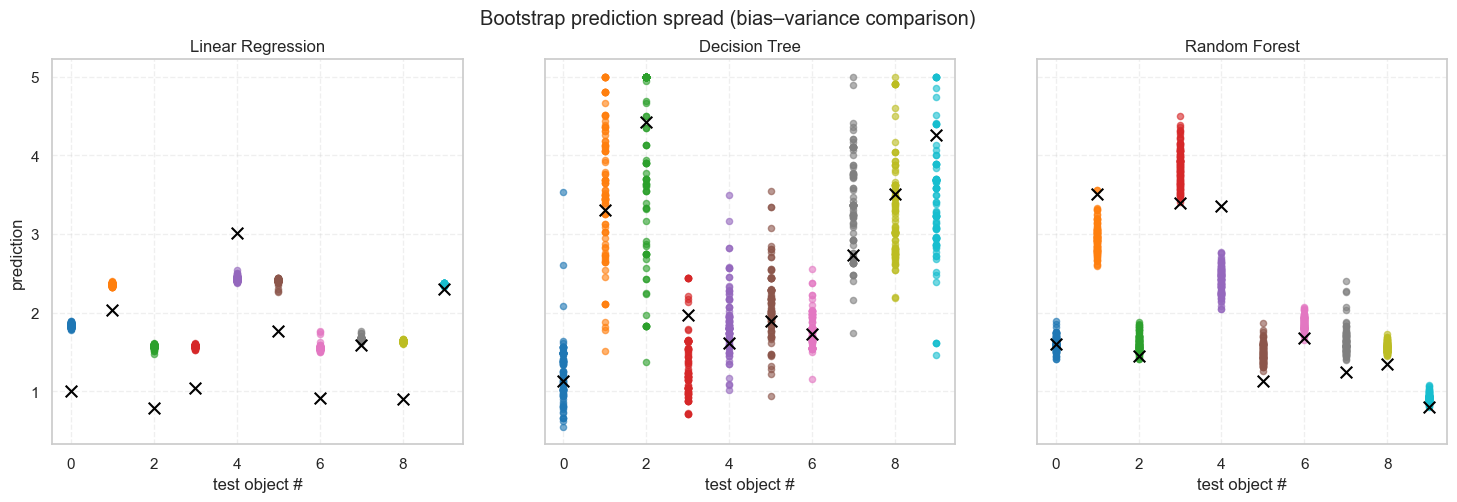

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

plot_predictions(
    LinearRegression(),
    X, y,
    num_runs=100,
    num_test_objects=10,
    ax=axes[0],
    title="Linear Regression"
)

plot_predictions(
    DecisionTreeRegressor(),
    X, y,
    num_runs=100,
    num_test_objects=10,
    ax=axes[1],
    title="Decision Tree"
)

plot_predictions(
    RandomForestRegressor(n_estimators=50),
    X, y,
    num_runs=100,
    num_test_objects=10,
    ax=axes[2],
    title="Random Forest"
)

axes[0].set_ylabel("prediction")
plt.suptitle("Bootstrap prediction spread (bias–variance comparison)")
plt.show()


<font color='blue'>**Ответ:**  </font>

1. **Linear Regression**\
Разброс:предсказания бутстрэп‑реплик почти совпадают. низкая дисперсиямодели, она стабильна относительно изменения обучающей выборки.\
Смещение: для многих объектов центр кластеров заметно отстоит от истинного значения (крестика), мб есть систематическая ошибка\
  
даёт стабильные, но иногда систематически неверные предсказания, если данные действительно линейны, то нормально.

2. **Decision Tree**\
 Разброс: очень большой — для каждого объекта точки сильно рассеиваются по вертикали. дерево чувствительно к изменениям данных (каждая бутстрэп‑реплика даёт существенно иное дерево).\
Смещение: центры распределений часто находятся близко к истинным значениям (мало смещения), дерево способно подстраиваться под структуру данных и не заваливает среднее.\
  
одно дерево может дать точные по центру предсказания, но они очень нестабильны.

3. **Random Forest**\
Разброс: группы точек значительно уже, чем у одиночного дерева, но шире, чем у линейной регрессии — variance уменьшена по сравнению с деревом за счёт усреднения многих разнородных деревьев.\
Смещение: центры предсказаний обычно ближе к истинным значениям, чем у простой лин регрессии, и часто сопоставимы с центрами дерева\
  
уменьшает разброс деревьев без существенного увеличения смещения, поэтому часто показывает лучшую общую ошибку.
